In [1]:
from TO_sim.get_rrrp import get_K_r_rp,get_K_r_rp_full

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable

from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from scipy import interpolate
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)


def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan

In [3]:
K = 8
m = 6

$$ 𝑟_0−(𝑚𝐾𝑟_+)/(𝑚^2 𝜔_+^2+1) $$

In [54]:
R_set = []
R0_set = []
rp_set = []
Rs = np.linspace(0.01,1,200)
rps = np.linspace(0.001,0.5,100)
for R in Rs:
	R_s = []
	r0_s = []
	rp_s = []
	for rp in rps:
		X = K*R
		a = 1/np.sqrt(X*m)
		b = 4/np.pi * a - 0.3056*a**3
		b = np.where(a>1.193,1,b)
		OP = b*X
		r0,err = quad(integrand_Rl, -OP,OP,args=(K*R,0,1,m),limit=200)

		a = 1 / np.sqrt(K * rp * m)
		b = 4 / np.pi * a - 0.3056 * a**3
		b = np.where(a>1.193,1,b)
		OPs = max(b * K * rp, 0)

		delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

		RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
		RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
		rp_ = RP_l - RP_d
		R_ = r0 - (m*K*rp_)/(m**2*OP**2+1)
		R_s.append(R_-R)
		r0_s.append(r0)
		rp_s.append(rp_-rp)
	R_set.append(R_s)
	R0_set.append(r0_s)
	rp_set.append(rp_s)

C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\2186706486.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\2186706486.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r0,err = quad(integrand_Rl, -OP,OP,args=(K*R,0,1,m),limit=200)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\2186706486.py:25: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\2186706486.py:26: IntegrationWarning: The occur

In [48]:
from scipy.optimize import fsolve

In [49]:
def equations_to_solve(vars):
    """
    fsolve가 0으로 만들 목표 방정식을 정의하는 함수.
    vars: [R, rp] 형태의 리스트 또는 배열
    """
    R, rp = vars[0], vars[1]

    # --- 기존 코드의 계산 로직을 그대로 가져옵니다 ---
    
    # R에 대한 계산
    X = K * R
    a = 1 / np.sqrt(X * m)
    b = 4 / np.pi * a - 0.3056 * a**3
    b = 1 if a > 1.193 else b
    OP = b * X
    r0, err = quad(integrand_Rl, -OP, OP, args=(K * R, 0, 1, m), limit=200)

    # rp에 대한 계산
    a_s = 1 / np.sqrt(K * rp * m)
    b_s = 4 / np.pi * a_s - 0.3056 * a_s**3
    b_s = 1 if a_s > 1.193 else b_s
    OPs = max(b_s * K * rp, 0)

    delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + \
              (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

    RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
    RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
    
    # 최종 R_와 rp_ 계산
    rp_ = RP_l - RP_d
    R_ = r0 - (m * K * rp_) / (m**2 * OP**2 + 1)

    # fsolve는 이 함수의 반환값이 [0, 0]이 되는 R과 rp를 찾습니다.
    return [R_ - R, rp_ - rp]

In [50]:
initial_guess = [0.5, 0.5]

# fsolve를 사용하여 해를 찾습니다.
solution = fsolve(equations_to_solve, initial_guess)

# 결과 출력
solved_R = solution[0]
solved_rp = solution[1]

C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\785867116.py:19: RuntimeWarning: invalid value encountered in sqrt
  a_s = 1 / np.sqrt(K * rp * m)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\785867116.py:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\785867116.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r0, err = quad(integrand_Rl, -OP, OP, args=(K * R, 0, 1, m), limit=200)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\785867116.py:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  

In [52]:
solved_R,solved_rp

(0.6188798920137668, 0.09183876876959268)

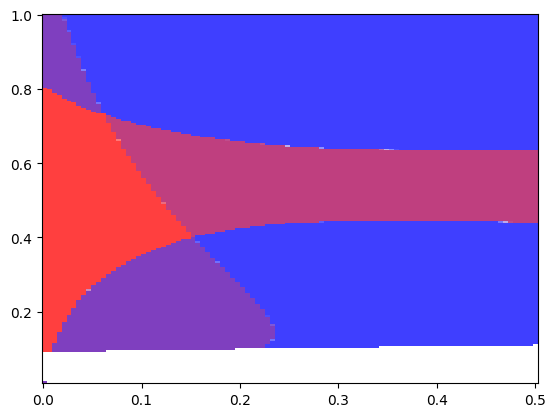

In [55]:
plt.pcolormesh(rps,Rs,rp_set,vmin=-0.0001,vmax=0.0001,cmap='bwr',alpha=0.5)
plt.pcolormesh(rps,Rs,R_set,vmin=-0.0001,vmax=0.0001,cmap='bwr',alpha=0.5)


In [4]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve



K = 5.5
m = 6
def equations_to_solve(vars):
    R, rp = vars
    # 이전과 동일한 계산 로직
    # ... (계산 코드는 생략)
    X = K * R
    a = 1 / np.sqrt(X * m) if X * m > 0 else np.inf
    b = 4 / np.pi * a - 0.3056 * a**3
    b = 1 if a > 1.193 else b
    OP = b * X if X > 0 else 0
    if OP == 0: return [999, 999] # 0으로 나누기 방지
    r0, _ = quad(integrand_Rl, -OP, OP, args=(K * R, 0, 1, m))

    a_s = 1 / np.sqrt(K * rp * m) if K * rp * m > 0 else np.inf
    b_s = 4 / np.pi * a_s - 0.3056 * a_s**3
    b_s = 1 if a_s > 1.193 else b_s
    OPs = max(b_s * K * rp, 0)

    delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + \
              (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

    RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m))
    RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m))
    
    rp_ = RP_l - RP_d
    R_ = r0 - (m * K * rp_) / (m**2 * OP**2 + 1)
    
    return [R_ - R, rp_ - rp]

# --- 여러 해 찾기 실행 ---

# 1. 탐색 범위 및 초기 추정값 그리드 생성
# R은 0.1부터 1.0까지 5개, rp는 0.1부터 1.0까지 5개의 시작점을 만듭니다.
# 총 5 * 5 = 25개의 초기 추정값 조합이 생성됩니다.
R_guesses = np.linspace(0.1, 1.0, 5)
rp_guesses = np.linspace(0.01, 0.5, 5)

found_solutions = []

# 2. 모든 초기 추정값 조합에 대해 fsolve 반복 실행
for r_guess in R_guesses:
    for rp_guess in rp_guesses:
        initial_guess = [r_guess, rp_guess]
        # full_output=True로 설정하여 수렴 정보를 받습니다. ier=1이면 수렴 성공입니다.
        solution, infodict, ier, mesg = fsolve(equations_to_solve, initial_guess, full_output=True)
        
        # 3. 수렴에 성공한 경우에만 해를 저장
        if ier == 1:
            found_solutions.append(solution)

# 4. 중복된 해 제거
# 소수점 5자리까지 비교하여 거의 같은 해는 하나로 취급합니다.
unique_solutions = []
if found_solutions:
    # 첫 번째 해는 무조건 추가
    unique_solutions.append(found_solutions[0])
    
    for sol in found_solutions[1:]:
        is_unique = True
        # 이미 찾은 해들과 비교
        for unique_sol in unique_solutions:
            # np.allclose는 두 배열이 허용 오차 내에서 거의 같은지 비교합니다.
            if np.allclose(sol, unique_sol, atol=1e-5):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)

# --- 최종 결과 출력 ---
if not unique_solutions:
    print("❌ 해를 찾지 못했습니다.")
else:
    print(f"✅ 총 {len(unique_solutions)}개의 고유한 해를 찾았습니다:")
    for i, sol in enumerate(unique_solutions):
        print(f"--- 해 #{i+1} ---")
        print(f"R  = {sol[0]:.6f}")
        print(f"rp = {sol[1]:.6f}")
        # 검증
        residuals = equations_to_solve(sol)
        print(f"검증 (R_ - R, rp_ - rp): [{residuals[0]:.2e}, {residuals[1]:.2e}]\n")

✅ 총 2개의 고유한 해를 찾았습니다:
--- 해 #1 ---
R  = 0.004741
rp = 0.000360
검증 (R_ - R, rp_ - rp): [1.43e-13, -6.76e-15]

--- 해 #2 ---
R  = 0.668700
rp = 0.000000
검증 (R_ - R, rp_ - rp): [-6.66e-16, 1.86e-15]



C:\Users\kim9y\AppData\Local\Temp\ipykernel_55020\1080926446.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r0, _ = quad(integrand_Rl, -OP, OP, args=(K * R, 0, 1, m))
C:\Users\kim9y\AppData\Local\Temp\ipykernel_55020\1080926446.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m))
C:\Users\kim9y\AppData\Local\Temp\ipykernel_55020\1080926446.py:29: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m))


In [65]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import least_squares

EPS = 1e-9
BIG = 1e6

def safe_val(x, lo, hi):
    # 경계 살짝 안쪽으로 밀기
    return min(max(x, lo + EPS), hi - EPS)

def residual(x, K, m):
    # ----- 입력 방어 -----
    R  = float(x[0]); rp = float(x[1])
    R  = safe_val(R,  0.0, 1.0)
    rp = safe_val(rp, 0.0, 1.0)

    if not np.isfinite(K) or not np.isfinite(m) or K <= 0 or m <= 0:
        return np.array([BIG, BIG], dtype=float)

    # ----- 공통 도우미 -----
    def finite_or_big(v):
        return v if (np.isfinite(v)) else BIG

    try:
        # X, a, b, OP
        X = K * R
        Xm = max(X * m, EPS)
        a  = 1.0 / np.sqrt(Xm)
        b  = 4/np.pi * a - 0.3056 * a**3
        if a > 1.193:  # 포화
            b = 1.0
        OP = max(b * X, EPS)

        # r0 적분 (유한 tol)
        r0, _ = quad(integrand_Rl, -OP, OP, args=(K*R, 0, 1, m),
                     epsabs=1e-10, epsrel=1e-10, limit=200)
        if not np.isfinite(r0):
            return np.array([BIG, BIG], dtype=float)

        # rp 쪽 a_s, b_s, OPs
        Krpm = max(K * rp * m, EPS)
        a_s  = 1.0 / np.sqrt(Krpm)
        b_s  = 4/np.pi * a_s - 0.3056 * a_s**3
        if a_s > 1.193:
            b_s = 1.0
        OPs = max(b_s * K * rp, 0.0)

        # delta_P (분모에 EPS)
        denom1 = (m**2 * OP**2 + 1.0)
        denom2 = (4.0 * m**2 * OP**2 + 1.0)
        delta_P = (m*K**2*r0*rp) / (2.0 * (denom1 + EPS)) \
                + (K**2 * rp**2) / (4.0 * max(OP, EPS) * (denom2 + EPS))

        lo = OP
        hi = OP + delta_P + OPs
        # 무한 적분 절단
        cut = hi + 12.0

        if not (np.isfinite(lo) and np.isfinite(hi) and hi > lo and np.isfinite(cut)):
            return np.array([BIG, BIG], dtype=float)

        RP_l, _ = quad(integrand_Rl3, lo, hi, args=(K*rp, OP, delta_P, m),
                       epsabs=1e-10, epsrel=1e-10, limit=200)
        RP_d, _ = quad(integrand_Rd , hi, cut, args=(K*rp, 0, 1, m),
                       epsabs=1e-10, epsrel=1e-10, limit=200)

        if not (np.isfinite(RP_l) and np.isfinite(RP_d)):
            return np.array([BIG, BIG], dtype=float)

        rp_ = RP_l - RP_d
        R_  = r0 - (m * K * rp_) / (denom1 + EPS)

        # 최종 잔차 (유한화)
        e1 = finite_or_big(R_  - R)
        e2 = finite_or_big(rp_ - rp)
        if not (np.isfinite(e1) and np.isfinite(e2)):
            return np.array([BIG, BIG], dtype=float)

        return np.array([e1, e2], dtype=float)

    except Exception:
        # 어떤 예외든 유한 큰 잔차 반환
        return np.array([BIG, BIG], dtype=float)


In [62]:
def dedupe(points, tol=1e-6):
    uniq = []
    for p in points:
        if all(np.linalg.norm(p - q) > tol for q in uniq):
            uniq.append(p)
    return uniq

def solve_at_K(K, m, seeds=None, n_grid=9,
               R_bounds=(0,1), rp_bounds=(0,1),
               tol_sol=1e-8, tol_sep=1e-5, max_deflate=4):
    sols = []

    # 1) 이전 해(seeds)가 있으면 우선 사용
    if seeds is None:
        seeds = []
    for x0 in seeds:
        res = least_squares(residual, x0, args=(K,m),
                            bounds=([R_bounds[0], rp_bounds[0]],
                                    [R_bounds[1], rp_bounds[1]]),
                            ftol=1e-12, xtol=1e-12, gtol=1e-12,
                            max_nfev=2000, method='trf')
        if res.success and np.linalg.norm(res.fun) < tol_sol:
            sols.append(np.clip(res.x, [0,0],[1,1]))

    # 2) 격자형 멀티스타트로 누락 보충
    R0s  = np.linspace(*R_bounds, n_grid)
    rp0s = np.linspace(*rp_bounds, n_grid)
    for R0 in R0s:
        for rp0 in rp0s:
            res = least_squares(residual, [R0,rp0], args=(K,m),
                                bounds=([R_bounds[0], rp_bounds[0]],
                                        [R_bounds[1], rp_bounds[1]]),
                                ftol=1e-12, xtol=1e-12, gtol=1e-12,
                                max_nfev=2000, method='trf')
            if res.success and np.linalg.norm(res.fun) < tol_sol:
                sols.append(np.clip(res.x, [0,0],[1,1]))

    sols = dedupe(sols, tol=tol_sep)

    # 3) (선택) 디플레이션으로 추가 해 강제
    def def_res(x, roots, p=2.0, eps=1e-6):
        F = residual(x, K, m)
        if not roots:
            return F
        prod = 1.0
        for r in roots:
            prod *= (np.linalg.norm(x - r)**p + eps)
        return F / prod

    trials = 0
    while trials < max_deflate:
        trials += 1
        found = False
        # 무작위 시드 몇 개
        for _ in range(10):
            x0 = np.array([np.random.uniform(*R_bounds),
                           np.random.uniform(*rp_bounds)])
            res = least_squares(lambda x: def_res(x, sols), x0,
                                bounds=([R_bounds[0], rp_bounds[0]],
                                        [R_bounds[1], rp_bounds[1]]),
                                ftol=1e-12, xtol=1e-12, gtol=1e-12,
                                max_nfev=2000, method='trf')
            if res.success and np.linalg.norm(res.fun) < tol_sol:
                x = np.clip(res.x, [0,0],[1,1])
                if all(np.linalg.norm(x - s) > tol_sep for s in sols):
                    sols.append(x); found = True
        if not found:  # 더 이상 새 해가 안 나옴
            break

    return np.array(sols)


In [66]:
def predict_next_seed(branch_pts, K_vals):
    # branch_pts: [(K1, [R,rp]), (K2, [R,rp]), ...] (K 오름차순)
    if len(branch_pts) < 2:
        return branch_pts[-1][1]
    (K1, x1), (K2, x2) = branch_pts[-2], branch_pts[-1]
    dK = K2 - K1
    if abs(dK) < 1e-12:
        return x2
    slope = (x2 - x1) / dK
    return x2 + slope * (K2 - K1)  # 다음 K로 가기 직전 예측치(소폭 도움)

def continuation_over_K(K_grid, m, n_grid=9):
    K_grid = np.array(K_grid)
    solutions_map = {}   # K -> array of roots at K
    branches = []        # 각 가지: [(K, array([R,rp])), ...]

    prev_roots = None
    for i, K in enumerate(K_grid):
        # 1) 이전 해를 씨앗으로
        seeds = []
        if prev_roots is not None:
            seeds += [r.copy() for r in prev_roots]

        # 2) K에서 여러 해 수집
        roots = solve_at_K(K, m, seeds=seeds, n_grid=n_grid)
        solutions_map[K] = roots
        if roots.size == 0:
            prev_roots = None
            continue

        # 3) 가지 매칭/업데이트
        if i == 0 or prev_roots is None or len(branches) == 0:
            # 첫 지점: 각 해로 가지 생성
            for r in roots:
                branches.append([(K, r)])
        else:
            # 이전 지점의 마지막 해들과 현재 해들을 매칭
            used = set()
            # 간단한 greedy 최근접 매칭
            for b in branches:
                # b의 마지막 K가 직전인지 확인
                if b[-1][0] != K_grid[i-1]:
                    continue
                x_prev = b[-1][1]
                dists = np.linalg.norm(roots - x_prev, axis=1)
                idx = int(np.argmin(dists))
                if idx not in used and dists[idx] < 5e-2:  # 매칭 임계값(스케일에 맞춰 조절)
                    b.append((K, roots[idx])); used.add(idx)
            # 매칭 안 된 해들은 새 가지로 시작
            for j, r in enumerate(roots):
                if j not in used:
                    branches.append([(K, r)])

        prev_roots = roots

    return solutions_map, branches

def bidirectional_continuation(K_grid, m, n_grid=9):
    # 상향
    sols_up, br_up = continuation_over_K(K_grid, m, n_grid=n_grid)
    # 하향
    sols_dn, br_dn = continuation_over_K(K_grid[::-1], m, n_grid=n_grid)
    # 합치기(간단히 이어붙이고 나중에 플로팅 시 중복 자연스레 겹침)
    return (sols_up, br_up, sols_dn, br_dn)


C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\3464306394.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r0, _ = quad(integrand_Rl, -OP, OP, args=(K*R, 0, 1, m),
C:\Users\kim9y\AppData\Local\Temp\ipykernel_39832\3464306394.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_l, _ = quad(integrand_Rl3, lo, hi, args=(K*rp, OP, delta_P, m),


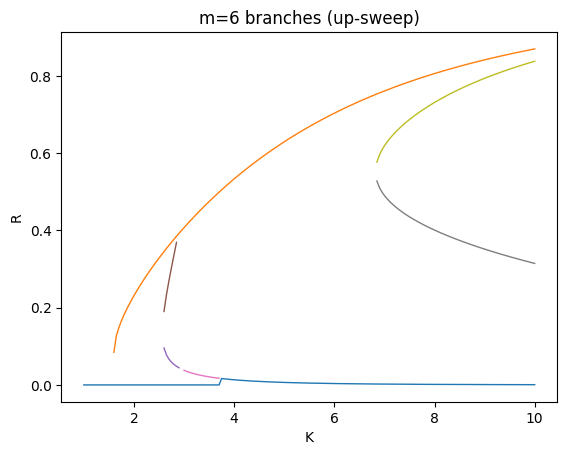

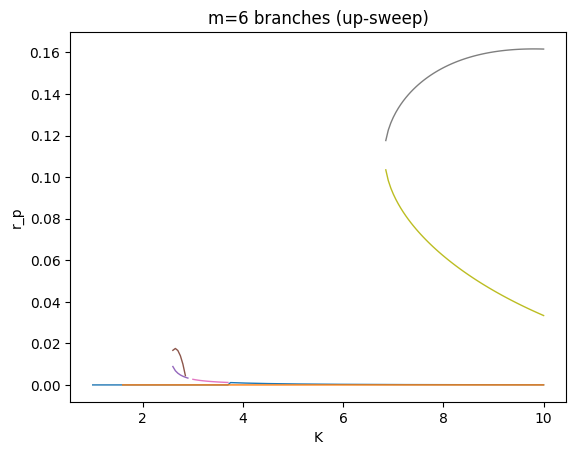

In [67]:
# 예: m 고정, K=0.5~10.0까지 0.05 간격
m_fixed = 6
K_grid = np.linspace(0.5, 10.0, 191)

sols_up, branches_up, sols_dn, branches_dn = bidirectional_continuation(K_grid, m_fixed, n_grid=9)

# branches_* 는 분기 가지별로 (K, [R,rp]) 시퀀스가 들어 있음
# 시각화 예시:
import matplotlib.pyplot as plt

plt.figure()
for br in branches_up:
    br = sorted(br, key=lambda t: t[0])
    Ks = [t[0] for t in br]
    Rs = [t[1][0] for t in br]
    plt.plot(Ks, Rs, '-', lw=1)
plt.xlabel('K'); plt.ylabel('R'); plt.title(f'm={m_fixed} branches (up-sweep)')
plt.show()

plt.figure()
for br in branches_up:
    br = sorted(br, key=lambda t: t[0])
    Ks = [t[0] for t in br]
    rps = [t[1][1] for t in br]
    plt.plot(Ks, rps, '-', lw=1)
plt.xlabel('K'); plt.ylabel('r_p'); plt.title(f'm={m_fixed} branches (up-sweep)')
plt.show()


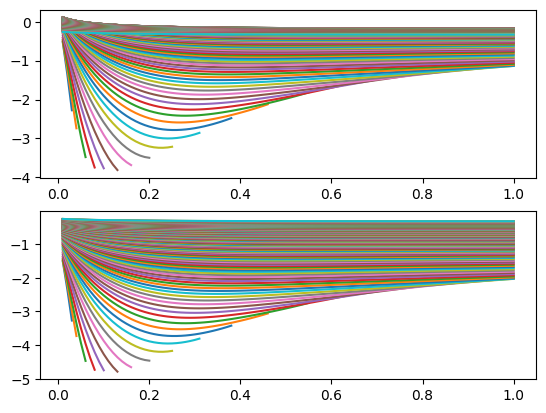

In [21]:
plt.subplot(211)

plt.plot(rps,np.array(R_set).T-Rs);
plt.subplot(212)
plt.plot(rps,np.array(R_set).T-rp);


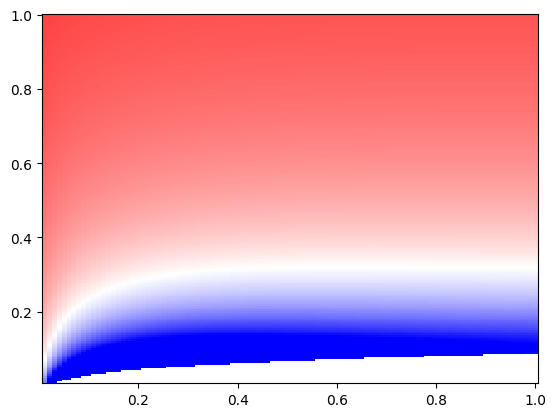

In [15]:
plt.pcolormesh(rps,Rs,R_set,vmin=-1,vmax=1,cmap='bwr')
# np.array(R0_set).reshape(100,100)
# np.array(rp_set).reshape(100,100)


⚙️ m = 4 (고정) 값에 대해 K를 바꿔가며 해를 탐색합니다.



C:\Users\kim9y\AppData\Local\Temp\ipykernel_55020\1238614806.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r0, _ = quad(integrand_Rl, -OP, OP, args=(K * R, 0, 1, m))
C:\Users\kim9y\AppData\Local\Temp\ipykernel_55020\1238614806.py:34: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m))
C:\Users\kim9y\AppData\Local\Temp\ipykernel_55020\1238614806.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m))
C:\Users\kim9y\AppData\Local\Temp\ipykernel_55020\1238614806.py:34: IntegrationWarning: The occurrence of roundoff error is det

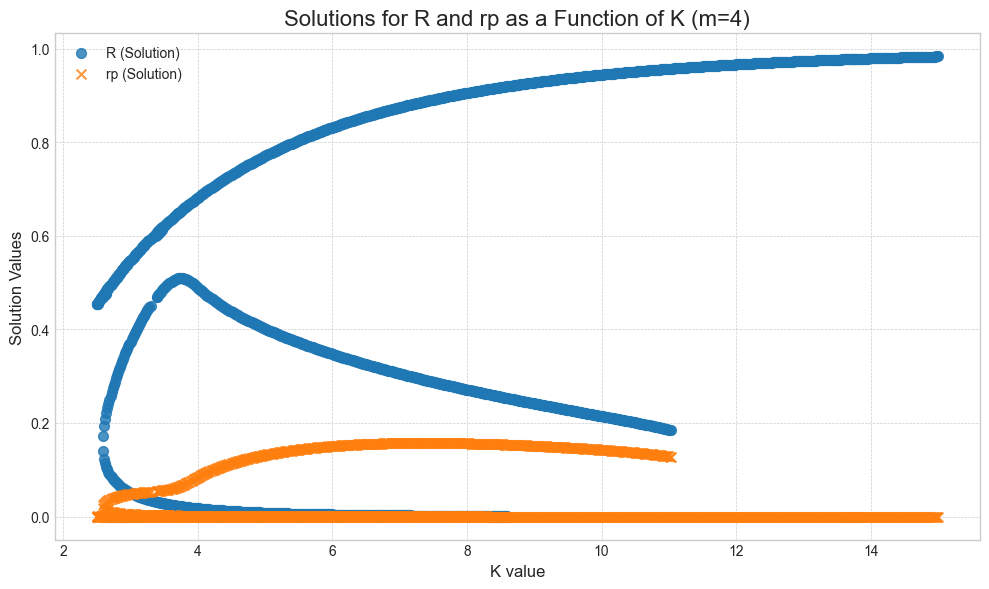

In [22]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib.style as style


def equations_to_solve(vars, K, m):
    """fsolve가 풀 방정식. K와 m을 추가 인자로 받도록 수정합니다."""
    R, rp = vars
    
    if K <= 0 or m <= 0 or R <= 0 or rp <= 0:
        return [999, 999]

    X = K * R
    a = 1 / np.sqrt(X * m)
    b = 4 / np.pi * a - 0.3056 * a**3
    b = 1 if a > 1.193 else b
    OP = b * X
    
    if OP == 0:
        return [999, 999]

    r0, _ = quad(integrand_Rl, -OP, OP, args=(K * R, 0, 1, m))

    a_s = 1 / np.sqrt(K * rp * m)
    b_s = 4 / np.pi * a_s - 0.3056 * a_s**3
    b_s = 1 if a_s > 1.193 else b_s
    OPs = max(b_s * K * rp, 0)

    delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + \
              (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

    RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m))
    RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m))
    
    rp_ = RP_l - RP_d
    R_ = r0 - (m * K * rp_) / (m**2 * OP**2 + 1)
    
    return [R_ - R, rp_ - rp]

# --- 1. 시뮬레이션 파라미터 설정 ---
m_fixed = 4
# 더 부드러운 그래프를 위해 K_values 개수를 늘립니다.
K_values = np.linspace(2.5, 15, 800)

R_guesses = np.linspace(0.01, 1.0, 10)
rp_guesses = np.linspace(0.01, 0.5, 10)

solutions_by_K = {}

# --- 2. K에 대한 외부 루프 실행 ---
print(f"⚙️ m = {m_fixed} (고정) 값에 대해 K를 바꿔가며 해를 탐색합니다.\n")
for K_val in K_values:
    # ... (이전과 동일한 계산 로직, 출력문은 생략) ...
    unique_solutions = [] # 여기에 고유 해를 저장
    found_solutions = []
    for r_guess in R_guesses:
        for rp_guess in rp_guesses:
            initial_guess = [r_guess, rp_guess]
            solution, infodict, ier, mesg = fsolve(equations_to_solve, initial_guess, args=(K_val, m_fixed), full_output=True)
            if ier == 1:
                found_solutions.append(solution)
    if found_solutions:
        unique_solutions.append(found_solutions[0])
        for sol in found_solutions[1:]:
            if not any(np.allclose(sol, usol, atol=1e-5) for usol in unique_solutions):
                unique_solutions.append(sol)
    solutions_by_K[K_val] = unique_solutions

# --- 3. 그래프 그리기 ---

# 그래프에 필요한 데이터를 준비합니다.
k_plot = []
r_plot = []
rp_plot = []

for K_val, solutions in solutions_by_K.items():
    for sol in solutions:
        k_plot.append(K_val)
        r_plot.append(sol[0])  # R 값
        rp_plot.append(sol[1]) # rp 값

# 그래프 스타일 설정
style.use('seaborn-v0_8-whitegrid')

# 그래프 객체 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 산점도 그리기
ax.scatter(k_plot, r_plot, label='R (Solution)', alpha=0.8, s=50, marker='o')
ax.scatter(k_plot, rp_plot, label='rp (Solution)', alpha=0.8, s=50, marker='x')

# 그래프 제목 및 라벨 설정
ax.set_title(f'Solutions for R and rp as a Function of K (m={m_fixed})', fontsize=16)
ax.set_xlabel('K value', fontsize=12)
ax.set_ylabel('Solution Values', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 그래프 표시
plt.tight_layout()
plt.show()

In [84]:
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd

In [23]:
m = m_fixed
R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start = get_K_r_rp_full(m)

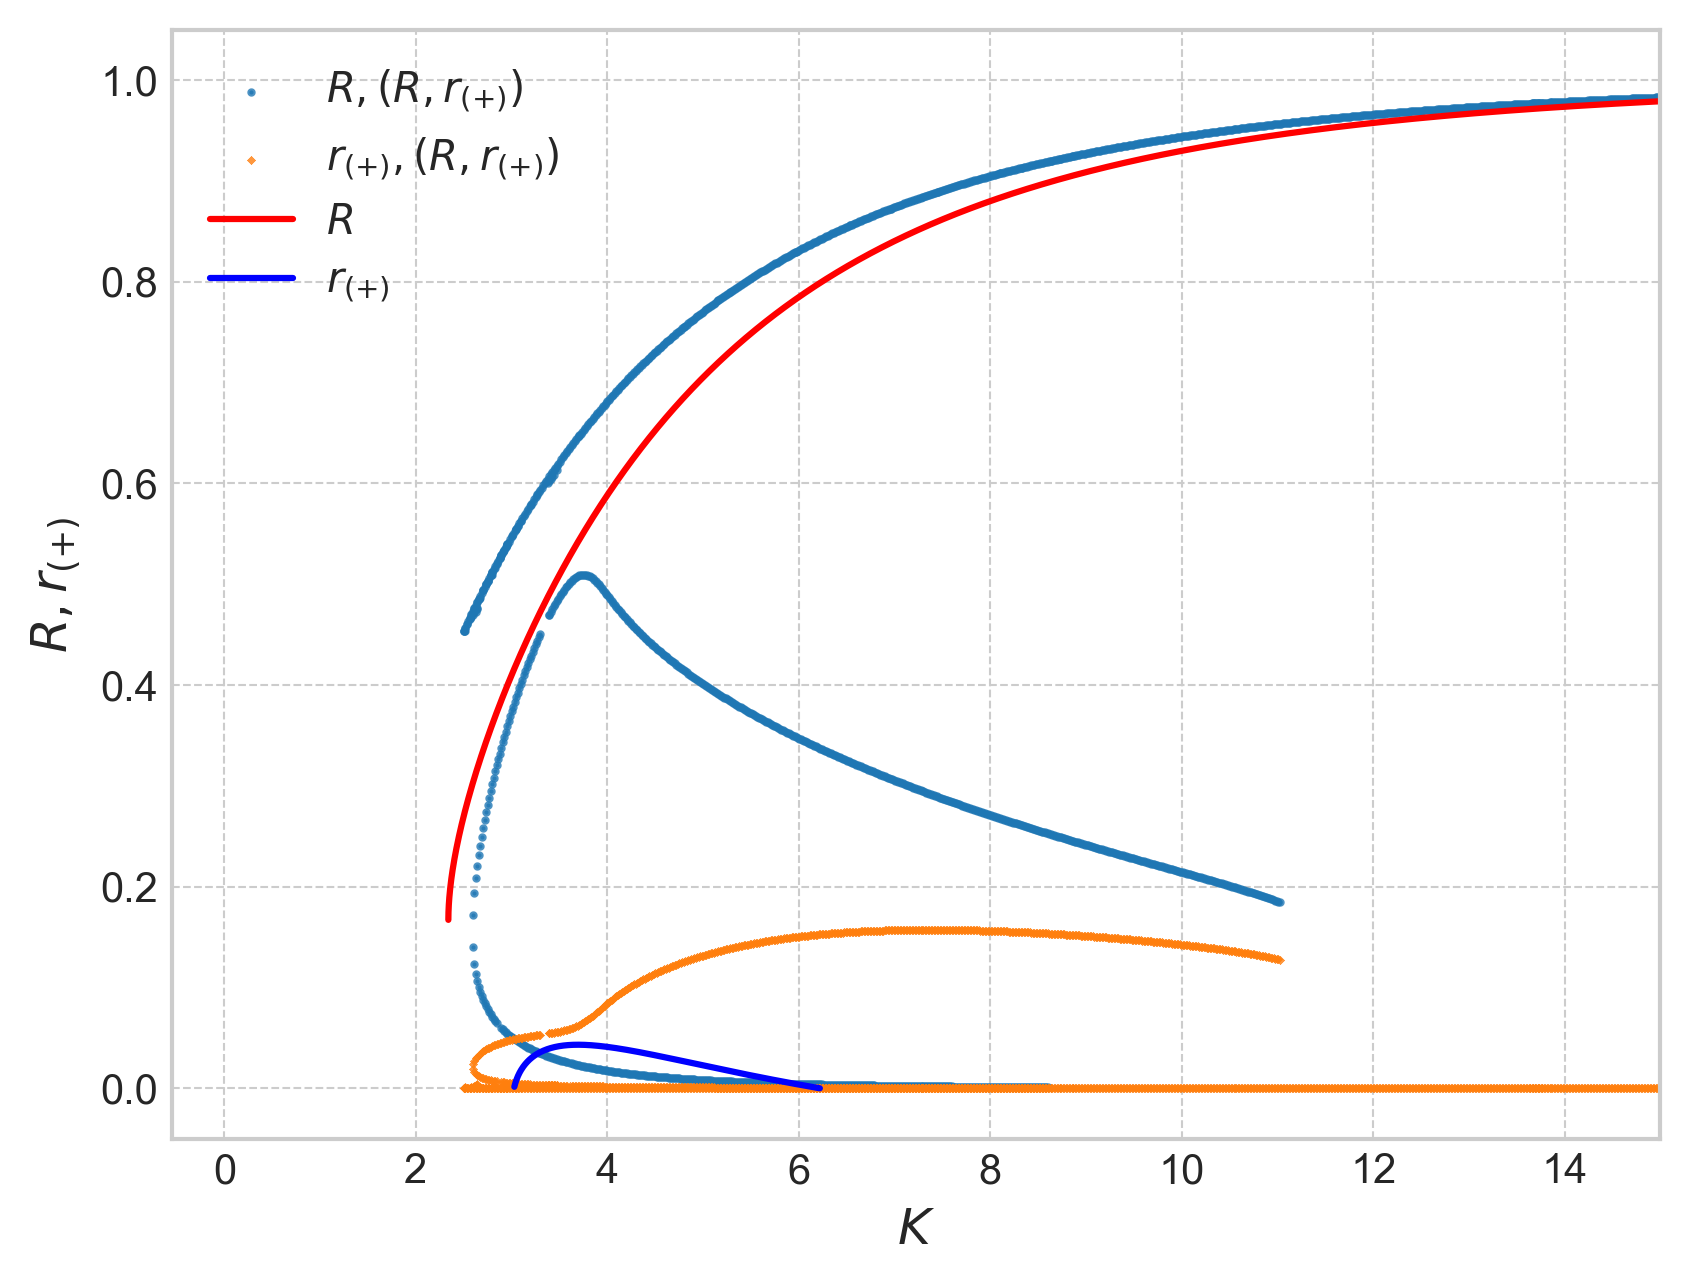

In [24]:
# 그래프 객체 생성
fig, ax = plt.subplots(dpi=300)
ax.scatter(k_plot, r_plot, label=r'$R,(R,r_{(+)})$', alpha=0.8, s=1, marker='o')
ax.scatter(k_plot, rp_plot, label=r'$r_{(+)},(R,r_{(+)})$', alpha=0.8, s=1, marker='x')
ax.plot(K1p,R_u,color='red',label=r'$R$')
ax.plot(K1p,RP1_u,color='blue',label=r'$r_{(+)}$')

# ax.plot(K1p,R_d)
# ax.plot(K1p,RP1_d)

ax.set_xlim(right=15)
# 그래프 제목 및 라벨 설정
# ax.set_title(f'Solutions for R and rp as a Function of K (m={m_fixed})', fontsize=16)
ax.set_xlabel(r'$K$', fontsize=12)
ax.set_ylabel(r'$R, r_{(+)}$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

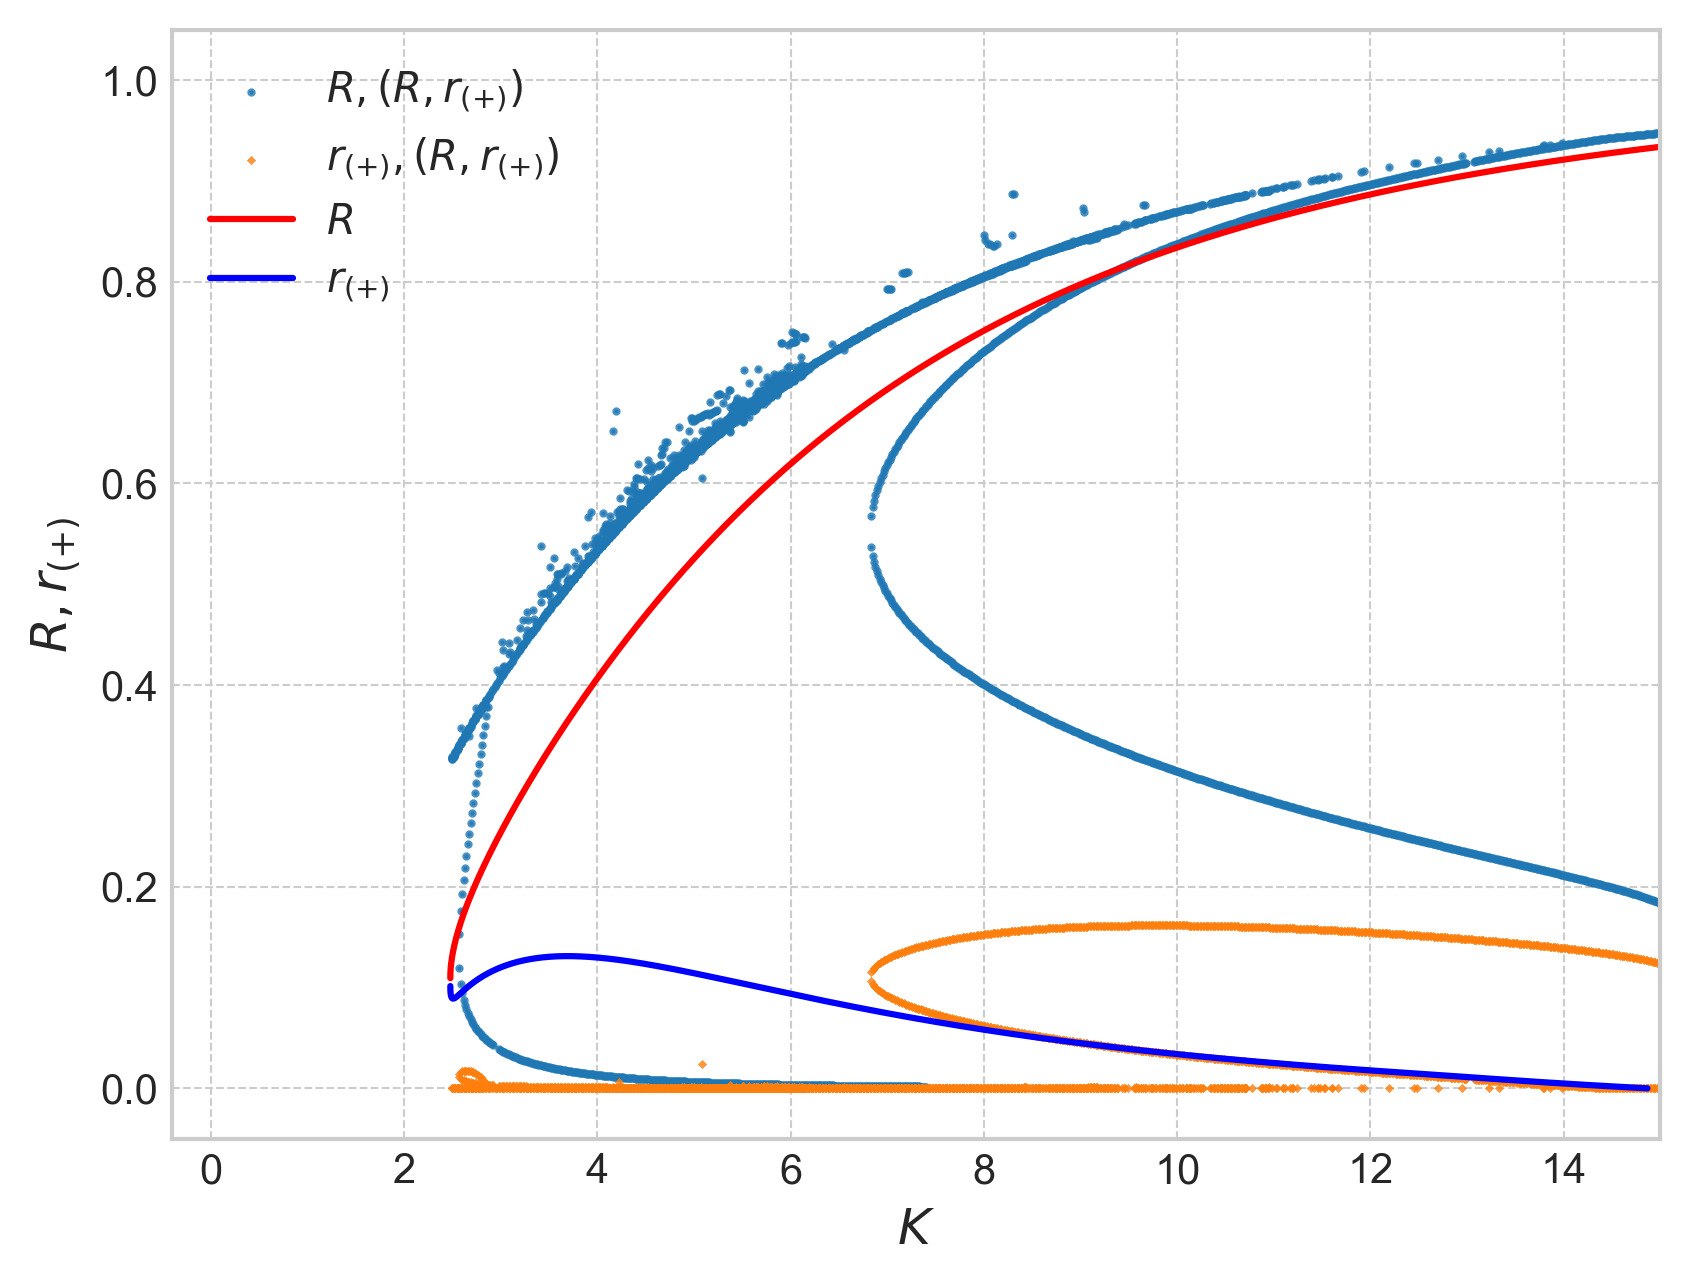

In [20]:
# 그래프 객체 생성
fig, ax = plt.subplots(dpi=300)
ax.scatter(k_plot, r_plot, label=r'$R,(R,r_{(+)})$', alpha=0.8, s=1, marker='o')
ax.scatter(k_plot, rp_plot, label=r'$r_{(+)},(R,r_{(+)})$', alpha=0.8, s=1, marker='x')
ax.plot(K1p,R_u,color='red',label=r'$R$')
ax.plot(K1p,RP1_u,color='blue',label=r'$r_{(+)}$')

# ax.plot(K1p,R_d)
# ax.plot(K1p,RP1_d)

ax.set_xlim(right=15)
# 그래프 제목 및 라벨 설정
# ax.set_title(f'Solutions for R and rp as a Function of K (m={m_fixed})', fontsize=16)
ax.set_xlabel(r'$K$', fontsize=12)
ax.set_ylabel(r'$R, r_{(+)}$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)